In [1]:
import math
import onnxruntime
import pandas as pd
import numpy as np
from sim.sim_env import MoabSim
import PIL
import matplotlib.pyplot as plt

In [2]:
# Launch an onnxruntime session to run inference on the policy
session = onnxruntime.InferenceSession("outputs/rllib_model.onnx")

# Initialize the simulation environment
sim = MoabSim(env_config=None)

In [3]:
def logits_to_actions(logits):
        # Define low and high values
        low = np.array([-1, -1], dtype=np.float32)
        high = np.array([1, 1], dtype=np.float32)
        # Define a constant for the minimum log value to avoid numerical issues
        MIN_LOG_VALUE = -1e7
        # Split the logits into mean and log_std
        split_index = len(logits) // 2
        means, log_stds = logits[:split_index], logits[split_index:]
        actions = []
        i = 0
        for mean, log_std in zip(means, log_stds):
            # Clip the log_std to a reasonable range
            log_std = max(min(log_std, -MIN_LOG_VALUE), MIN_LOG_VALUE)
            # Compute the std from the log_std
            std = math.exp(log_std)
            # Create a normal distribution with the mean and std
            normal_dist = [mean, std]
            # Sample a value from the normal distribution
            normal_sample = mean # use the mean for deterministic output
            # Apply a tanh function to the normal sample
            tanh_sample = math.tanh(normal_sample)
            # Scale the tanh sample by the low and high bounds of the action space
            action = low[i] + (high[i] - low[i]) * (tanh_sample + 1) / 2
            actions.append(action)
            i += 1
        # Return the list of actions
        return actions



In [4]:
# Episodes
n_episodes = 30
logs = []
for episode in range(n_episodes):
    # Resets the environment
    sim.reset()
    # Runs the simulation while the episode is not terminated or truncated
    terminated = False
    truncated = False
    step = 0
    while not terminated and not truncated:
        # Run inference on the observation and get the logits.
        logits = session.run(None, {"obs": [sim._get_obs()], "state_ins": [None]})[0][0]
        actions = logits_to_actions(logits)
        state, reward, terminated, truncated, _ = sim.step(actions)
        step += 1
        # Logs
        log = {}
        log["episode"] = episode
        log["step"] = step
        log["ball_x"] = state[0]
        log["ball_y"] = state[1]
        log["ball_vel_x"] = state[2]
        log["ball_vel_y"] = state[3]
        log["input_pitch"] = actions[0]
        log["input_roll"] = actions[1]
        log["reward"] = reward
        log["terminated"] = terminated
        log["truncated"] = truncated
        logs.append(log)

logs_df = pd.DataFrame(logs)

In [5]:
# Adding columns for plotting
logs_df["plot_marker_size"] = logs_df["step"] ** 4 / 3e6 + 20
logs_df["plot_marker_alpha"] = logs_df["step"] ** 5 / 2e10 + 0.3
logs_df.loc[(logs_df["terminated"] | logs_df["truncated"]), "plot_marker_alpha"] = 1

def generate_plot(episode_id, logs_df):
    fig, ax = plt.subplots()
    circle = plt.Circle((0, 0), 0.1125, color="lightgray") # Create a circle object
    ax.add_patch(circle) 
    ax.set_aspect("equal")
    ax.set_xlim(-0.15, 0.15)
    ax.set_ylim(-0.15, 0.15)
    # Plot the trajectory using step, ball_x and ball_y from logs_df
    episode_logs = logs_df.loc[logs_df["episode"] == episode_id]
    scatter = plt.scatter(episode_logs["ball_x"],
                          episode_logs["ball_y"],
                          c=episode_logs["reward"],
                          s=episode_logs["plot_marker_size"],
                          alpha=episode_logs["plot_marker_alpha"],
                          cmap="plasma") 
    cbar = fig.colorbar(scatter)
    cbar.ax.set_title("Reward", fontsize=10)
    plt.clim(0, 1)
    # Add a line connecting the steps
    plt.plot(episode_logs["ball_x"], episode_logs["ball_y"], color="gray", linewidth=1)
    # Add an arrow at the last step
    dx, dy = episode_logs["ball_vel_x"].iloc[-1], episode_logs["ball_vel_y"].iloc[-1]
    dx, dy = 0.01 * np.array([dx, dy]) / np.hypot(dx, dy)
    plt.arrow(episode_logs["ball_x"].iloc[-1], episode_logs["ball_y"].iloc[-1],
              dx, dy, head_width=0.008, length_includes_head=True,
              head_starts_at_zero=True, color="black", linewidth=0)
    # Show the plot
    plt.title(f"Moab Ball Trajectory #{episode_id+1}")
    plt.xlabel("ball_x")
    plt.ylabel("ball_y")
    plt.close(fig)
    fig.canvas.draw()
    img = PIL.Image.frombytes("RGB", fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    return img

imgs = [generate_plot(episode_id, logs_df) for episode_id in range(n_episodes)]

/var/folders/90/6x51pxbn6vl_spycvr6r218w0000gn/T/ipykernel_87636/2599455782.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = PIL.Image.frombytes("RGB", fig.canvas.get_width_height(),fig.canvas.tostring_rgb())


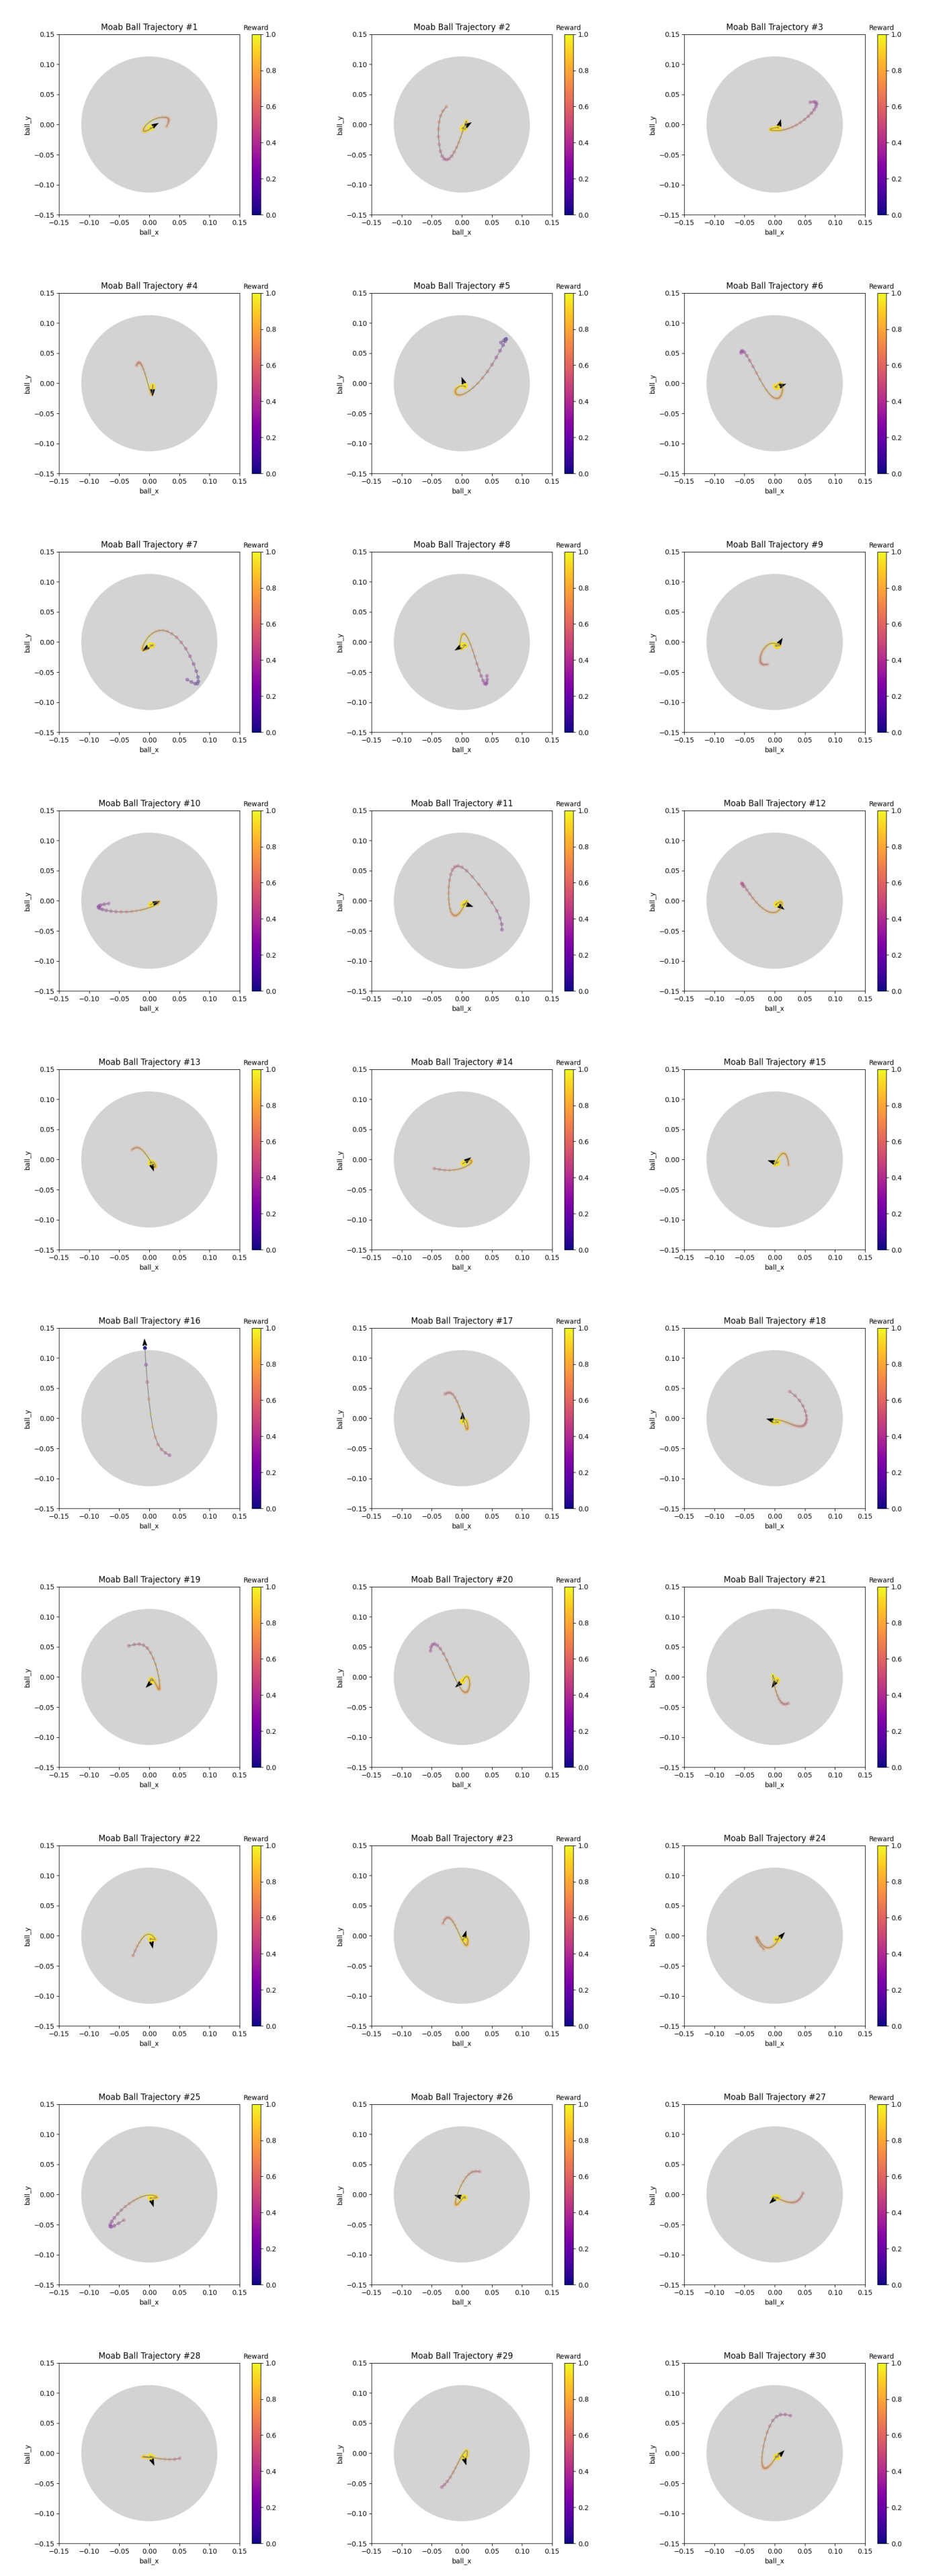

In [6]:
_, axs = plt.subplots(10, 3, figsize=(18, 50))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()